Below I'll include my own code

In [ ]:
!pip install torchaudio
!pip uninstall librosa
!pip install librosa

In [ ]:
import torch
import numpy as np
import torchaudio
import torch.nn as nn
import librosa
import librosa.display
import matplotlib.pyplot as plt
from google.colab import drive
import copy
drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
contentFile = '/content/drive/MyDrive/Audio Neural Style Transfer/Content.mp3'


cuda


In [ ]:
#the normalize flag normalizes by magnitude after stft
#this method slices the audio into smaller pieces and converts each of those pieces into MelSpectrograms
def createAudioFeatures(audioFile, normalize=False):
  """This method splits the audio into segments of 0.5 second and creates Spectrogram for each of those segments"""
  # waveform, sample_rate = torchaudio.load(audioFile) #waveform is already normalized between [-1,1]
  waveform, sample_rate = librosa.load(audioFile, sr=None) #ignore the warning generated with this command execution, the waveform returned is a numpy array
  waveform = waveform.reshape(1,-1) #waveform is now of shape (1, datapoints)
  print("Shape of waveform: ",waveform.shape) 
  print("Sample rate of waveform: ",sample_rate)

  segmentSize = 0.5 #0.5 seconds
  segmentDataSize = int(0.5*sample_rate) #this many data points constitute 0.5 seconds(segementSize)
  segmentsNo = waveform.shape[1]//segmentDataSize #there will be this many segments. If the audio file was 5 seconds in size and segMentSize was 0.5, segmentsNo = 5/0.5 = 10
  # print("segmentDataPointSize: ",segmentDataSize,"\n segmentsNo: ",segmentsNo)

  #sample_rate is 48000Hz, n_fft = 400, hoplength = 400/2 = 200. 
  #so the output size of melSpectrogram of each audio segment of 0.5 seconds would be [channel, mel_bins, (48000/200)*0.5 + 1] = [1,128,121]
  spectrogram = torch.zeros(segmentsNo, 1, 128, int((sample_rate/200)*0.5) +1)
  # print("spectrogram shape: ",spectrogram.shape)

  for i in range(segmentsNo):
    b = i*segmentDataSize
    specgram = torchaudio.transforms.MelSpectrogram(normalized=normalize)(waveform[:,b:b+segmentDataSize])
    specgram = specgram
    spectrogram[i] = specgram

  return spectrogram/torch.max(spectrogram) #normalizing the values between [0,1]


In [ ]:
specContent = createAudioFeatures(contentFile)
print("spectrogram shape: ",specContent.shape,"\nrandom sampling[2,1,128,20:25]: ",specContent[2,:,1,20:25])
plt.figure()
p = plt.imshow(specContent[0,0,:,:].log2().detach().numpy(), cmap='hot')
print("maxVal = ",torch.max(specContent)," minVal= ",torch.min(specContent))

In [ ]:
#this method converts the audioform of the whole audio to MelSpectrogram. It doesn't slice the audio into smaller pieces
def createAudioFeatures2(audioFile, normalize=False):

  waveform, sample_rate = librosa.load(audioFile, sr=None) #ignore the warning generated with this command execution, the waveform return is a numpy array
  print("waveform shape: ",waveform.shape) #(datapoints, ); datapoints = length_of_audio * sample_rate
  print("sample rate: ",sample_rate)

  
  """Calculations for determining the shape of the returned spectrogram
      n_fft = 2048, hop_length = 512, sample_rate = 48K, audio_length = 5.664 seconds
      shape of spectrogram = (mel_bins, (sample_rate/hop_length)*audio_length + 1) = (128, int((48000/512)*5.664) + 1) = (128, 512)
  """

  melSpect = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

  return torch.from_numpy(melSpect).to(device, torch.float)

In [ ]:

specContent = createAudioFeatures2(contentFile)
print("shape of melSpectrogram: ", specContent.shape)
# print(specContent.device)


/usr/local/lib/python3.6/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


waveform shape:  (271872,)
sample rate:  48000
shape of melSpectrogram:  torch.Size([128, 532])


In [ ]:
class ContentCNN(nn.Module):

  def __init__(self):
    super(ContentCNN, self).__init__()

    """conv1d layers, compress and extract info from time domain"""
    self.conv1 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=2)
    self.conv2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=5, stride=1)
    self.conv3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=5, stride=1)

    """conv 2d layers"""
    self.conv4 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1)
    self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
    self.conv6 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
    self.conv7 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
    self.conv8 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1)

    """fully connected layers"""
    self.fc1 = nn.Linear(in_features=128*26*26, out_features=5048)
    self.fc2 = nn.Linear(in_features=5048, out_features=1600)

  #X will be a melspectrogram of the content audio
  #X will be of shape (128, 532) numpy array
  #also I will have return the activations of a certain layer l for the computation of loss
  #the aforementioned l can be neither too shallow nor too deep in the network
  #so for now I choose l to be conv6
  def forward(self, X):

    ret = None

    #convert X into an torch of shape (1,128, 532)
    X_torch = X.unsqueeze(0)
    # print("X_torch.shape: ", X_torch.shape)

    X_torch = nn.ReLU()(self.conv1(X_torch))
    # print("requires_grad: ", X_torch.requires_grad)
    # print("X_torch.shape: ", X_torch.shape)
    X_torch = nn.ReLU()(self.conv2(X_torch))
    # print("X_torch.shape: ", X_torch.shape)
    X_torch = nn.ReLU()(self.conv3(X_torch))
    # print("X_torch.shape: ", X_torch.shape)

    X_torch = nn.MaxPool2d(kernel_size=2, stride = 2)(X_torch)
    X_torch = X_torch.unsqueeze(0)
    # print("X_torch.shape: ",X_torch.shape)

    X_torch = nn.ReLU()(self.conv4(X_torch))
    # print("X_torch.shape: ", X_torch.shape)
    X_torch = nn.ReLU()(self.conv5(X_torch))
    # print("X_torch.shape: ", X_torch.shape)
    X_torch = nn.ReLU()(self.conv6(X_torch))
    ret = X_torch
    # print("X_torch.shape: ", X_torch.shape)

    X_torch = nn.MaxPool2d(kernel_size=2, stride=2)(X_torch)
    # print("X_torch.shape: ",X_torch.shape)

    X_torch = nn.ReLU()(self.conv7(X_torch))
    # print("X_torch.shape: ", X_torch.shape)
    X_torch = nn.ReLU()(self.conv8(X_torch))
    # print("X_torch.shape: ", X_torch.shape)

    X_torch = nn.MaxPool2d(kernel_size=2, stride = 2)(X_torch)
    # print("X_torch.shape: ",X_torch.shape)
    X_torch = X_torch.reshape(1, -1)
    # print("X_torch.shape: ",X_torch.shape)

    X_torch = nn.ReLU()(self.fc1(X_torch))
    # print("X_torch.shape: ", X_torch.shape)
    X_torch = nn.ReLU()(self.fc2(X_torch))
    # print(X_torch.device)
    # print("X_torch.shape: ", X_torch.shape)

    return ret


In [ ]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    # noise_image = torch.rand(content_image.shape, requires_grad=True)
    noise_image = torch.FloatTensor(content_image.shape).uniform_(-20.0, 20.0).to(device)
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    print("input_image.requires_grad: ", input_image.requires_grad, " grad_fn: ",input_image.grad_fn)

    return input_image

In [ ]:
contentSpec = createAudioFeatures2(contentFile)
generatedSpec = generate_noise_image(contentSpec)

/usr/local/lib/python3.6/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


waveform shape:  (271872,)
sample rate:  48000
input_image.requires_grad:  False  grad_fn:  None


In [ ]:
import matplotlib.pyplot as plt
def showSpectrogram(spectrogram):
  spectrogram = spectrogram.detach().clone().cpu()
  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(spectrogram, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=48000,
                          fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram')

In [ ]:
import torch.optim as optim
def constructAudio(contentSpec, generatedSpec, epoch=80000):
  
  cEncoder = ContentCNN()
  cEncoder.to(device)
  #this creates a criterion which is simply the elementwise sum of squared differences. 
  #This is the loss that was used in the Coursera course
  criterion = nn.MSELoss(reduce='sum') 
  # optimizer = optim.SGD( list(cEncoder.parameters()) + [generatedSpec.requires_grad_()], lr=0.001, momentum=0.9)
  optimizer = optim.Adam( list(cEncoder.parameters()) + [generatedSpec.requires_grad_()], lr=0.01)
  showSpectrogram(generatedSpec)

  for e in range(epoch):
    
    optimizer.zero_grad()
    c_outputs = cEncoder.forward(contentSpec)
    g_outputs = cEncoder.forward(generatedSpec)
    # print("c_outputs.shape: ",c_outputs.shape)
    # print("g_outputs.shape: ",g_outputs.shape)

    loss = criterion(c_outputs, g_outputs)
    if e%10000==0:
      print("epoch ",e,": ",loss.item())
    loss.backward()
    optimizer.step()
  showSpectrogram(generatedSpec)
  # print("original audio")
  # plt.figure()
  # p = plt.imshow(contentSpec.unsqueeze(1)[0,0,:,:].log2().detach().numpy(), cmap='hot')  

  # print("decoded audio")
  # plt.figure()
  # p1 = plt.imshow(d_outputs.unsqueeze(1)[0,0,:,:].log2().detach().numpy(), cmap='hot')
  # return d_outputs 

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


epoch  0 :  0.003202031599357724
epoch  10000 :  0.0
epoch  20000 :  0.0
epoch  30000 :  0.0
epoch  40000 :  0.0
epoch  50000 :  0.0
epoch  60000 :  0.0
epoch  70000 :  0.0
epoch  80000 :  0.0
epoch  90000 :  0.0
epoch  100000 :  0.0
epoch  110000 :  0.0
epoch  120000 :  0.0
epoch  130000 :  0.0
epoch  140000 :  0.0
epoch  150000 :  0.0


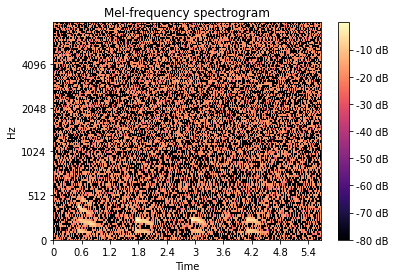

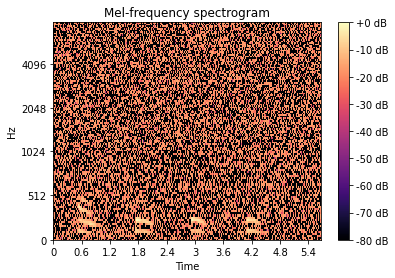

In [ ]:
decodedAudio = constructAudio(contentSpec, generatedSpec, epoch=160000)

In [ ]:
decodedSegments = []
for i in range(decodedAudio.shape[0]):
  decodedSegments.append(librosa.feature.inverse.mel_to_audio(decodedAudio[i].detach().numpy()))
print(decodedSegments[0].shape,", ",decodedSegments[1].shape)

(61440,) ,  (61440,)


In [ ]:
import wave
import struct
def convertSignalToWav(decodedSegments):
  """Convert a numpy array into a wav file.

     Args
     ----
     signal : 1-D numpy array
         An array containing the audio signal.
     fname : str
         Name of the audio file where the signal will be saved.
     Fs: int
        Sampling rate of the signal.

  """
  for i in range(len(decodedSegments)): 
    signal = decodedSegments[i]
    # print(signal)
    data = struct.pack('<' + ('f'*len(signal)), *signal)
    wav_file = wave.open("output"+str(i)+".wav", 'wb')
    wav_file.setnchannels(1)
    wav_file.setsampwidth(4)
    wav_file.setframerate(48000)
    wav_file.writeframes(data)

In [ ]:
convertSignalToWav(decodedSegments)

In [ ]:
!pip install pydub
from pydub import AudioSegment
combinedSound = AudioSegment.from_wav("output0.wav")
for i in range(1,11):
  sound = AudioSegment.from_wav("output"+str(i)+".wav")
  combinedSound = combinedSound + sound
combinedSound.export("joinedFile.wav", format="wav")

<_io.BufferedRandom name='joinedFile.wav'>